In [1]:
# To import the data we need the dicom library
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

import importlib
from tqdm import tqdm
import pickle

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

import aux_preprocessing as aux

In [2]:
week1data = aux._getstudies("Thorax_Abdomen/week1/DICOMDIR")
week2data = aux._getstudies("Thorax_Abdomen/week2/DICOMDIR")
week3data = aux._getstudies("Thorax_Abdomen/week3/DICOMDIR")
week4data = aux._getstudies("Thorax_Abdomen/week4/DICOMDIR")
week5data = aux._getstudies("Thorax_Abdomen/week5/DICOMDIR")
week6data = aux._getstudies("Thorax_Abdomen/week6/DICOMDIR")
week7data = aux._getstudies("Thorax_Abdomen/week7/DICOMDIR")

In [3]:
week22data = aux._getstudies("Thorax_Abdomen/week2_2/DICOMDIR")
week23data = aux._getstudies("Thorax_Abdomen/week2_3/DICOMDIR")
week24data = aux._getstudies("Thorax_Abdomen/week2_4/DICOMDIR")
week25data = aux._getstudies("Thorax_Abdomen/week2_5/DICOMDIR")
week32data = aux._getstudies("Thorax_Abdomen/week3_2/DICOMDIR")
week33data = aux._getstudies("Thorax_Abdomen/week3_3/DICOMDIR")
week72data = aux._getstudies("Thorax_Abdomen/week7_2/DICOMDIR")

# Functions to determine size of a patient

In [4]:
def sizeSlice(s):
    ## determines the amount of pixels that are above the threshold for a slice
    threshold_mask = s.pixel_array > 800
    tmpmask = ndimage.binary_erosion(threshold_mask,iterations =6)
    closedmask = ndimage.binary_fill_holes(tmpmask)
    n_pixels = np.sum(closedmask)      ## # pixels above threshold
    v_pixel = s.PixelSpacing[0]*s.PixelSpacing[1]*s.SliceThickness *10**(-6) # volume 1 pixel in liters
    return n_pixels*v_pixel

def sizeSlice_wo_hollow(s):
    threshold_mask = s.pixel_array > 800
    tmpmask = ndimage.binary_erosion(threshold_mask,iterations =6)
    n_pixels = np.sum(tmpmask)      ## # pixels above threshold
    v_pixel = s.PixelSpacing[0]*s.PixelSpacing[1]*s.SliceThickness *10**(-6) # volume 1 pixel in liters
    return n_pixels*v_pixel

def sizePatient(patient):
    ## gives volume of scanned body in liters
    volume = 0
    for s in patient:
        volume += sizeSlice(s)
    return volume



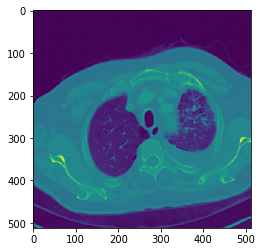

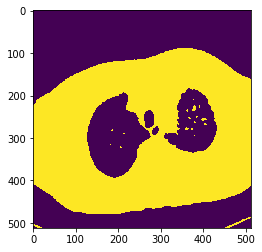

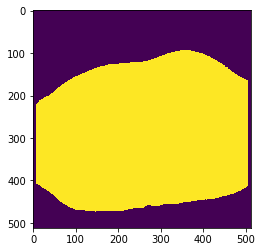

volume of the full slice 0.316 dm^3
volume of the slice without hollow parts 0.240 dm^3
volume of the whole patient 46.160 dm^3


In [5]:
scan0 = week1data['E864M5E14Q'][0][8]
slice0 = scan0[10]

tmparr = slice0.pixel_array
tmpmask = tmparr > 800
closedmask = ndimage.binary_erosion(tmpmask,iterations =6)
closedmask = ndimage.binary_fill_holes(closedmask)

plt.imshow(tmparr)
plt.show()
plt.imshow(tmpmask)
plt.show()
plt.imshow(closedmask)
plt.show()

print('volume of the full slice {:.3f} dm^3'.format(sizeSlice(slice0)))
print('volume of the slice without hollow parts {:.3f} dm^3'.format(sizeSlice_wo_hollow(slice0)))
print('volume of the whole patient {:.3f} dm^3'.format(sizePatient(scan0)))

## Measure of quality

In [31]:
cv2.Laplacian(tmparr, cv2.CV_64F).var()


NameError: name 'cv2' is not defined

#  Save results

save results in a list containting al the values for the different size features, obtained from the pictures

In [27]:
### Create pickle file containing size features
relev_feats = ['Size',               ## Size of the body, using the filled in pictrure
               'Size_hollow',        ## Size of the body without the hollow parts
               'Im_mean',
              ]            ## Mean value of the pixels in the images

relev_feats = ['size', 'size_hollow', 'perimeter', 'meanhu']


importlib.reload(aux)
x = []

week = 1    
weekname = 'week'+str(week)+'data'
weekdata = eval(weekname)
slicce = week1data['E864M5E16Q'][0][1][0]
x = aux.imageFeatures(slicce)

p = len(x)
print(p)
print(x)

4
[0.18768908660888672, 0.18244256904602052, 1318.477272147525, 1081.084279965361]


In [29]:
### Create pickle file containing size features

importlib.reload(aux)

X = np.empty((0,p))

# 
relev_feats = ['size', 'size_hollow', 'perimeter', 'meanhu']

for week in tqdm([1,2,22,23,24,25,3,32,33,4,5,6,7,72]):
    Yi = np.empty((0,1))
    Xi = np.empty((0,p))
    weekname = 'week'+str(week)+'data'
    weekdata = eval(weekname)
    for scan in list(weekdata.keys()):
        for series in list(weekdata[scan][0].keys()):
            for slicce in weekdata[scan][0][series]:
                x = aux.imageFeatures(slicce)
#                 for feat in relev_feats:
#                     x = x+aux.get_feature_value(slicce,feat)
                Xi = np.append(Xi,[np.array(x)],axis=0)
    X = np.append(X,Xi,axis=0)



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [04:11<00:00, 20.06s/it]


In [30]:
## save the data
with open('data/X_sizes.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(X, f)

with open('data/X_sizes_labels.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(relev_feats,f)

    

[2, 3, 4, 5]

So the size has a positive correlation with the dosis used. The regression line is described by $$dose = reg.coef_ \cdot size(dm^3)+ reg.intercept_$$

TODO
- Add function to python file
- Add size without hollow parts,
- Size off differnt organs (bones, fat, etc.)
- function per slice


- image quality, high gradients, maybe gradient at boundary of the body

